<a href="https://colab.research.google.com/github/imalka97/Test/blob/master/kera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import numpy as np  
import pandas as pd  
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data set

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/1Project/Model/train.csv')

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/1Project/Model/test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
valid_data = pd.read_csv('/content/drive/MyDrive/1Project/Model/valid.csv')

In [ ]:
test_data.shape[0]

3563475

In [ ]:
X_train = df.iloc[:,:5].values
Y_train = df.iloc[:,5:].values

In [ ]:
Y_val = valid_data.iloc[:,5:].values


In [ ]:
X_testq1 = test_data.iloc[:1000,1:2].values
X_testq2 = test_data.iloc[:1000, 2:].values

In [ ]:
s1 = X_train[:,3]
s2 = X_train[:,4]

# Preprocessing

In [ ]:
def tokenize(s):
    tokens = []
    tokens = [word_tokenize(str(sentence)) for sentence in s]

    rm1 = []
    for w in tokens:
        sm = re.sub('[^A-Za-z]',' ', str(w))
        x = re.split("\s", sm)
        rm1.append(x)
        
    return rm1


In [ ]:
def lower_case(s):
    #Removing whitespaces    
    for sent in s:
        while '' in sent:
            sent.remove('')

    # Lowercasing
    low = []
    for i in s:
        i = [x.lower() for x in i]
        low.append(i)
        
    return low

In [ ]:
def lemmatize(s):
    lemma = []
    wnl = WordNetLemmatizer()
    for doc in s:
        tokens = [wnl.lemmatize(w) for w in doc]
        lemma.append(tokens)

    # Removing Stopwords
    filter_words = []
    Stopwords = set(stopwords.words('english'))

    #ab = spell('nd')
    for sent in lemma:
        tokens = [w for w in sent if w not in Stopwords]
        filter_words.append(tokens)

    space = ' ' 
    sentences = []
    for sentence in filter_words:
        sentences.append(space.join(sentence))
        
    return sentences

In [ ]:
MAX_NB_WORDS = 200000
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(list(df['question1'].values.astype(str))+list(df['question2'].values.astype(str)))

In [ ]:
# X_train_q1 = tokenizer.texts_to_sequences(np.array(listq1))
X_train_q1 = tokenizer.texts_to_sequences(df['question1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding='post')

# X_train_q2 = tokenizer.texts_to_sequences(np.array(listq2))
X_train_q2 = tokenizer.texts_to_sequences(df['question2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding='post')

# Validation Data

In [ ]:
# X_train_q1 = tokenizer.texts_to_sequences(np.array(listq1))
X_val_q1 = tokenizer.texts_to_sequences(valid_data['question1'].values.astype(str))
X_val_q1 = pad_sequences(X_train_q1, maxlen = 30, padding='post')

# X_train_q2 = tokenizer.texts_to_sequences(np.array(listq2))
X_val_q2 = tokenizer.texts_to_sequences(valid_data['question2'].values.astype(str))
X_val_q2 = pad_sequences(X_train_q2, maxlen = 30, padding='post')

In [ ]:
X_test_q1 = tokenizer.texts_to_sequences(X_testq1.ravel())
X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')

X_test_q2 = tokenizer.texts_to_sequences(X_testq2.astype(str).ravel())
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [ ]:
word_index = tokenizer.word_index

# Load word embedding

In [ ]:
embedding_index = {}
with open('/content/drive/MyDrive/1Project/Model/glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_index[word] = vectors
    f.close()

In [ ]:
embedding_matrix = np.random.random((len(word_index)+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model creation

In [ ]:
# Model for Q1
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
model_q1 = tf.keras.Sequential()
model_q1.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 100,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q1.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q1.add(Dropout(0.2))
model_q1.add(LSTM(128, return_sequences = True))
model_q1.add(LSTM(128))
model_q1.add(Dense(60, activation = 'tanh'))
model_q1.add(Dense(2, activation = 'sigmoid'))


In [ ]:
# Model for Q2
model_q2 = tf.keras.Sequential()
model_q2.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 100,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q2.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q2.add(Dropout(0.2))
model_q2.add(LSTM(128, return_sequences = True))
model_q2.add(LSTM(128))
model_q2.add(Dense(60, activation = 'tanh'))
model_q2.add(Dense(2, activation = 'sigmoid'))

In [ ]:
# Merging the output of the two models,i.e, model_q1 and model_q2
mergedOut = Multiply()([model_q1.output, model_q2.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)

In [ ]:
new_model = Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
history = new_model.fit([X_train_q1,X_train_q2],Y_train, batch_size = 2000, validation_data= ([X_val_q1,X_val_q2],Y_val), epochs = 10)

Epoch 1/10
50/50 [==============================] - 490s 10s/step - loss: 0.6639 - accuracy: 0.6268 - val_loss: 0.6607 - val_accuracy: 0.6275
Epoch 2/10
50/50 [==============================] - 481s 10s/step - loss: 0.6538 - accuracy: 0.6275 - val_loss: 0.6413 - val_accuracy: 0.6275
Epoch 3/10
50/50 [==============================] - 472s 9s/step - loss: 0.6193 - accuracy: 0.6405 - val_loss: 0.5875 - val_accuracy: 0.6791
Epoch 4/10
50/50 [==============================] - 472s 9s/step - loss: 0.5679 - accuracy: 0.7057 - val_loss: 0.5344 - val_accuracy: 0.7365
Epoch 5/10
50/50 [==============================] - 478s 10s/step - loss: 0.5292 - accuracy: 0.7407 - val_loss: 0.5131 - val_accuracy: 0.7528
Epoch 6/10
50/50 [==============================] - 479s 10s/step - loss: 0.4999 - accuracy: 0.7628 - val_loss: 0.4706 - val_accuracy: 0.7816
Epoch 7/10
50/50 [==============================] - 480s 10s/step - loss: 0.4678 - accuracy: 0.7841 - val_loss: 0.4382 - val_accuracy: 0.8049
Epoch 8/

# Model evaluation

In [ ]:
accr = new_model.evaluate([X_val_q1,X_val_q2],Y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3125/3125 [==============================] - 157s 50ms/step - loss: 0.3477 - accuracy: 0.8548
Test set
  Loss: 0.348
  Accuracy: 0.855


<Figure size 432x288 with 0 Axes>

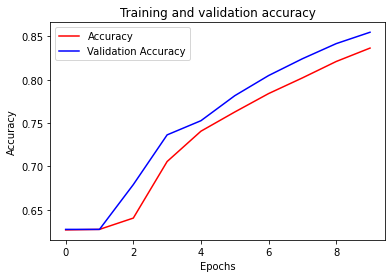

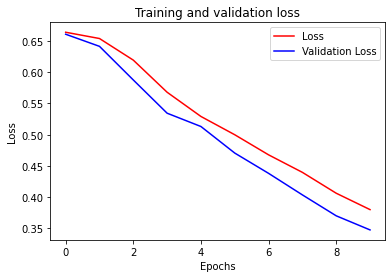

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.figure()

# Save Trained Model

In [ ]:
new_model.save('/content/drive/MyDrive/1Project/Model/answer_classifer.h5')

In [ ]:
y_pred = new_model.predict([X_test_q1, X_test_q2], batch_size=2000, verbose=1)
y_pred += new_model.predict([X_test_q1, X_test_q2], batch_size=2000, verbose=1)
 

1/1 [==============================] - 1s 1s/step


In [ ]:
y_pred = new_model.predict([X_test_q1, X_test_q2])

# Load Saved Model

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
import datetime
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
model=load_model('/content/drive/MyDrive/1Project/Model/answer_classifer.h5')

In [ ]:
tokenizer = Tokenizer()
def predict_text(q1,q2):
    X_test_q1 = tokenizer.texts_to_sequences(q1)
    X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')
    
    X_test_q2 = tokenizer.texts_to_sequences(q2)
    X_test_q2 = pad_sequences(X_test_q1,maxlen = 30, padding='post')
    prediction=model.predict([X_test_q1,X_test_q2])
    print(prediction)
    overall=((prediction[0][0]+prediction[0][1])/2)
    print(overall)

 

In [ ]:
q1=["in the developing world Computer Interacting education is vastly improving area."]
q2=["The integration of AR to the leaning process of a university, drives unparalleled attention from students."]
predict_text(q1,q2)

[[0.40160695 0.49824008]]
0.4499235153198242
